# Backpropagation and Multilayer Neural Networks

### Goals: 
- Intro: train a neural network with high level framework `Keras`
- Diving deep: implement a real gradient descent in `Numpy`
- Auto-differentiation: the basics of `TensorFlow`

### Dataset:
- Digits: 10 class handwritten digits
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

In [19]:
%matplotlib inline 
# display figures in the notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

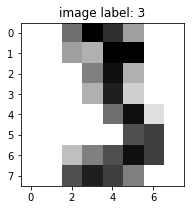

In [20]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization
- train/test split

In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

Let's display the one of the transformed sample (after feature standardization):

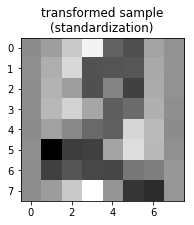

In [22]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardization)");

The scaler objects makes it possible to recover the original sample:

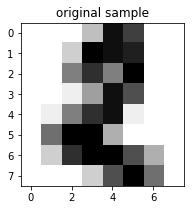

In [23]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1527, 64) (1527,)
(270, 64) (270,)


In [25]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train)

#  Numpy Implementation

## Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

In [26]:
## Functions defined during numpy_regression
EPSILON = 1e-8


def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)


def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [27]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

In [28]:
def sigmoid(X):
    res = 1 / (1+np.exp(-X))
    return res


def dsigmoid(X):
    res = np.exp(-X) / (1 + np.exp(-X))**2
    return res

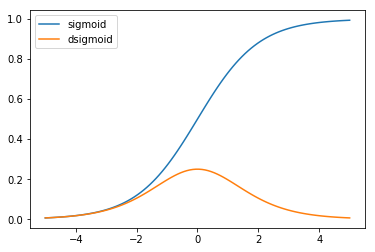

In [29]:
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer, similar to the first one in Keras:
  - $h = sigmoid(\mathbf{W}^h x + b^h)$
  - $y = softmax(\mathbf{W}^o h + b^o)$

Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- update the grad function to compute all gradients; check that the gradients are well defined;

- implement the `train` and `loss` functions.


Helps: 
  - grad_z_o = y - one_hot(output_size, y_true)
  - grad_W_o = outerproduct(h, grad_z_o)
  - grad_b_o = grad_z_o
  - grad_h = grad_z_o.W_o^T
  - grad_z_h = grad_h * dsigmoid(z_h)
  - grad_W_h = outerproduct(x,grad_z_h)
  - grad_b_h = grad_z_h

In [30]:
def softmax(X):
    e_x = np.exp(X)
    return e_x / e_x.sum(axis=-1, keepdims=True)

In [44]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=(hidden_size), high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=(output_size), high=0.1, low=-0.1)
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        
    def forward(self, X):
        hidden_calc = sigmoid(np.dot(X, self.W_h) + self.b_h)
        res = np.dot(hidden_calc, self.W_o) + self.b_o
        return softmax(res)
    
    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h
    
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x,grad_z_h)
        grad_b_h = grad_z_h
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [50]:
n_hidden = 20
model = NeuralNet(n_features, n_hidden, n_classes)

In [51]:
model.loss(X_train, y_train)

2.3081644923301554

In [52]:
model.accuracy(X_train, y_train)

0.079895219384413879

7


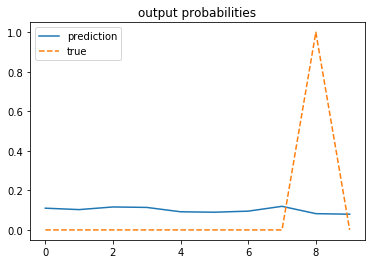

In [53]:
sample_idx = 1177
plt.plot(model.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(model.predict(X_train[sample_idx]))

In [54]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.3082, train acc: 0.080, test acc: 0.070
Epoch #1, train loss: 0.2144, train acc: 0.955, test acc: 0.933
Epoch #2, train loss: 0.1097, train acc: 0.977, test acc: 0.944
Epoch #3, train loss: 0.0681, train acc: 0.988, test acc: 0.956
Epoch #4, train loss: 0.0465, train acc: 0.996, test acc: 0.959
Epoch #5, train loss: 0.0355, train acc: 0.997, test acc: 0.959
Epoch #6, train loss: 0.0283, train acc: 0.997, test acc: 0.959
Epoch #7, train loss: 0.0217, train acc: 0.999, test acc: 0.963
Epoch #8, train loss: 0.0168, train acc: 0.999, test acc: 0.967
Epoch #9, train loss: 0.0140, train acc: 1.000, test acc: 0.967
Epoch #10, train loss: 0.0119, train acc: 1.000, test acc: 0.974
Epoch #11, train loss: 0.0103, train acc: 1.000, test acc: 0.974
Epoch #12, train loss: 0.0091, train acc: 1.000, test acc: 0.974
Epoch #13, train loss: 0.0081, train acc: 1.000, test acc: 0.974
Epoch #14, train loss: 0.0073, train acc: 1.000, test acc: 0.974
Epoch #15, train loss: 0.0067, t

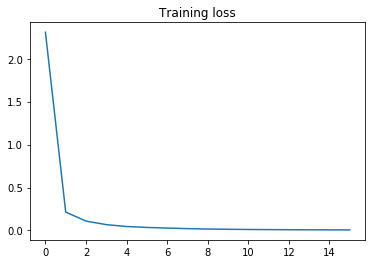

In [55]:
plt.plot(losses)
plt.title("Training loss");

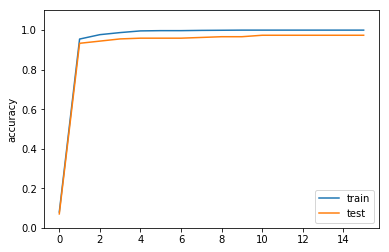

In [56]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

## c) Exercises

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- Bonus: the current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum